In [20]:
import os
import gdal
import zipfile
import numexpr
import datetime
import requests
import warnings
import odc.algo
import numpy as np
import pandas as pd
import xarray as xr
from collections import Counter
from scipy.ndimage import binary_dilation

import sys
import datacube    
sys.path.append('../../Scripts')
from dea_plotting import animated_timeseries

dc = datacube.Datacube(app='Animated timeseries')


def _dc_query_only(**kw):
    """
    Remove load-only parameters, the rest can be passed to Query
    Returns
    -------
    dict of query parameters
    """

    def _impl(measurements=None,
              output_crs=None,
              resolution=None,
              resampling=None,
              skip_broken_datasets=None,
              dask_chunks=None,
              fuse_func=None,
              align=None,
              datasets=None,
              progress_cbk=None,
              group_by=None,
              **query):
        return query

    return _impl(**kw)


def _common_bands(dc, products):
    """
    Takes a list of products and returns a list of measurements/bands
    that are present in all products
    Returns
    -------
    List of band names
    """
    common = None
    bands = None

    for p in products:
        p = dc.index.products.get_by_name(p)
        if common is None:
            common = set(p.measurements)
            bands = list(p.measurements)
        else:
            common = common.intersection(set(p.measurements))
    return [band for band in bands if band in common]


def load_ard(dc,
             products=None,
             min_gooddata=0.0,
             fmask_categories=['valid', 'snow', 'water'],
             mask_pixel_quality=True,
             mask_contiguity=False,
             ls7_slc_off=True,
             predicate=None,
             dtype='auto',
             **kwargs):

    """
    Loads and combines Landsat Collection 3 or Sentinel 2 Definitive 
    and Near Real Time data for multiple sensors (i.e. ls5t, ls7e and 
    ls8c for Landsat; s2a and s2b for Sentinel 2), optionally applies 
    pixel quality and contiguity masks, and drops time steps that 
    contain greater than a minimum proportion of good quality (e.g. non-
    cloudy or shadowed) pixels. 
    The function supports loading the following DEA products:
    
        ga_ls5t_ard_3
        ga_ls7e_ard_3
        ga_ls8c_ard_3
        s2a_ard_granule
        s2b_ard_granule
        s2a_nrt_granule
        s2b_nrt_granule
    Last modified: March 2020
    Parameters
    ----------
    dc : datacube Datacube object
        The Datacube to connect to, i.e. `dc = datacube.Datacube()`.
        This allows you to also use development datacubes if required.
    products : list
        A list of product names to load data from. Valid options are
        ['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'] for Landsat,
        ['s2a_ard_granule', 's2b_ard_granule'] for Sentinel 2 Definitive,
        and ['s2a_nrt_granule', 's2b_nrt_granule'] for Sentinel 2 Near
        Real Time (on the DEA Sandbox only).
    min_gooddata : float, optional
        An optional float giving the minimum percentage of good quality
        pixels required for a satellite observation to be loaded.
        Defaults to 0.0 which will return all observations regardless of
        pixel quality (set to e.g. 0.99 to return only observations with
        more than 99% good quality pixels).
    fmask_categories : list, optional
        An optional list of fmask category names to treat as good
        quality pixels in the above `min_gooddata` calculation, and for
        masking data by pixel quality (if `mask_pixel_quality=True`).
        The default is `['valid', 'snow', 'water']` which will return
        non-cloudy or shadowed land, snow and water pixels. Choose from:
        'nodata', 'valid', 'cloud', 'shadow', 'snow', and 'water'.
    mask_pixel_quality : bool, optional
        An optional boolean indicating whether to mask out poor quality
        pixels using fmask based on the `fmask_categories` provided 
        above. The default is True, which will set poor quality pixels 
        to NaN if `dtype='auto'` (which will convert the data to 
        'float32'), or set poor quality pixels to the data's native 
        nodata value if `dtype='native' (which can be useful for 
        reducing memory).         
    mask_contiguity : str or bool, optional
        An optional string or boolean indicating whether to mask out
        pixels missing data in any band (i.e. "non-contiguous" values).
        This can be important for generating clean composite datasets. 
        The default is False, which will ignore non-contiguous values 
        completely. If loading NBART data, set the parameter to:       
        `mask_contiguity='nbart_contiguity'`. If loading NBAR data, 
        specify `mask_contiguity='nbar_contiguity'` instead. 
        Non-contiguous pixels will be set to NaN if `dtype='auto'`, or 
        set to the data's native nodata value if `dtype='native'` 
        (which can be useful for reducing memory).
    dtype : string, optional
        An optional parameter that controls the data type/dtype that
        layers are coerced to after loading. Valid values: 'native', 
        'auto', 'float{16|32|64}'. When 'auto' is used, the data will be 
        converted to `float32` if masking is used, otherwise data will 
        be returned in the native data type of the data. Be aware that
        if data is loaded in its native dtype, nodata and masked 
        pixels will be returned with the data's native nodata value 
        (typically -999), not NaN. 
    ls7_slc_off : bool, optional
        An optional boolean indicating whether to include data from
        after the Landsat 7 SLC failure (i.e. SLC-off). Defaults to
        True, which keeps all Landsat 7 observations > May 31 2003.
    predicate : function, optional
        An optional function that can be passed in to restrict the
        datasets that are loaded by the function. A predicate function
        should take a `datacube.model.Dataset` object as an input (i.e.
        as returned from `dc.find_datasets`), and return a boolean.
        For example, a predicate function could be used to return True 
        for only datasets acquired in January:
        `dataset.time.begin.month == 1`
    **kwargs :
        A set of keyword arguments to `dc.load` that define the
        spatiotemporal query and load parameters used to extract data. 
        Keyword arguments can either be listed directly in the 
        `load_ard` call like any other parameter (e.g. 
        `measurements=['nbart_red']`), or by passing in a query kwarg 
        dictionary (e.g. `**query`). Keywords can include `measurements`, 
        `x`, `y`, `time`, `resolution`, `resampling`, `group_by`, `crs`;
        see the `dc.load` documentation for all possible options:
        https://datacube-core.readthedocs.io/en/latest/dev/api/generate/datacube.Datacube.load.html
    Returns
    -------
    combined_ds : xarray Dataset
        An xarray dataset containing only satellite observations that
        contains greater than `min_gooddata` proportion of good quality
        pixels.
    """

    #########
    # Setup #
    #########

    # Use 'nbart_contiguity' by default if mask_contiguity is true
    if mask_contiguity is True:
        mask_contiguity = 'nbart_contiguity'

    # We deal with `dask_chunks` separately
    dask_chunks = kwargs.pop('dask_chunks', None)
    requested_measurements = kwargs.pop('measurements', None)

    # Warn user if they combine lazy load with min_gooddata
    if (min_gooddata > 0.0) and dask_chunks is not None:
        warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "
                      "will cause dask arrays to compute when "
                      "loading pixel-quality data to calculate "
                      "'good pixel' percentage. This can "
                      "slow the return of your dataset.")

    # Verify that products were provided, and determine if Sentinel-2
    # or Landsat data is being loaded
    if not products:
        raise ValueError("Please provide a list of product names "
                         "to load data from. Valid options are: \n"
                         "['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'] "
                         "for Landsat, ['s2a_ard_granule', "
                         "'s2b_ard_granule'] \nfor Sentinel 2 Definitive, or "
                         "['s2a_nrt_granule', 's2b_nrt_granule'] for "
                         "Sentinel 2 Near Real Time")
    elif all(['ls' in product for product in products]):
        product_type = 'ls'
    elif all(['s2' in product for product in products]):
        product_type = 's2'

    fmask_band = 'fmask'
    measurements = requested_measurements.copy() if requested_measurements else None

    if measurements is None:
        
        # Deal with "load all" case: pick a set of bands common across 
        # all products
        measurements = _common_bands(dc, products)

        # If no `measurements` are specified, Landsat ancillary bands are 
        # loaded with a 'oa_' prefix, but Sentinel-2 bands are not. As a 
        # work-around, we need to rename the default contiguity and fmask 
        # bands if loading Landsat data without specifying `measurements`
        if product_type == 'ls':
            mask_contiguity = f'oa_{mask_contiguity}' if mask_contiguity else False
            fmask_band = f'oa_{fmask_band}'

    # If `measurements` are specified but do not include fmask or
    # contiguity variables, add these to `measurements`
    if fmask_band not in measurements:
        measurements.append(fmask_band)
    if mask_contiguity and mask_contiguity not in measurements:
        measurements.append(mask_contiguity)

    # Get list of data and mask bands so that we can later exclude
    # mask bands from being masked themselves
    data_bands = [band for band in measurements if band not in (fmask_band, mask_contiguity)]
    mask_bands = [band for band in measurements if band not in data_bands]

    #################
    # Find datasets #
    #################

    # Pull out query params only to pass to dc.find_datasets
    query = _dc_query_only(**kwargs)
    
    # Extract datasets for each product using subset of dcload_kwargs
    dataset_list = []

    # Get list of datasets for each product
    print('Finding datasets')
    for product in products:

        # Obtain list of datasets for product
        print(f'    {product} (ignoring SLC-off observations)' 
              if not ls7_slc_off and product == 'ga_ls7e_ard_3' 
              else f'    {product}')
        datasets = dc.find_datasets(product=product, **query)

        # Remove Landsat 7 SLC-off observations if ls7_slc_off=False
        if not ls7_slc_off and product == 'ga_ls7e_ard_3':
            datasets = [i for i in datasets if i.time.begin <
                        datetime.datetime(2003, 5, 31)]

        # Add any returned datasets to list
        dataset_list.extend(datasets)

    # Raise exception if no datasets are returned
    if len(dataset_list) == 0:
        raise ValueError("No data available for query: ensure that "
                         "the products specified have data for the "
                         "time and location requested")

    # If predicate is specified, use this function to filter the list
    # of datasets prior to load
    if predicate:
        print(f'Filtering datasets using predicate function')
        dataset_list = [ds for ds in dataset_list if predicate(ds)]

    # Raise exception if filtering removes all datasets
    if len(dataset_list) == 0:
        raise ValueError("No data available after filtering with "
                         "predicate function")

    #############
    # Load data #
    #############

    # Note we always load using dask here so that we can lazy load data 
    # before filtering by good data
    ds = dc.load(datasets=dataset_list,
                 measurements=measurements,
                 dask_chunks={} if dask_chunks is None else dask_chunks,
                 **kwargs)

    ####################
    # Filter good data #
    ####################

    # Calculate pixel quality mask
    pq_mask = odc.algo.fmask_to_bool(ds[fmask_band],
                                     categories=fmask_categories)

    # The good data percentage calculation has to load in all `fmask`
    # data, which can be slow. If the user has chosen no filtering
    # by using the default `min_gooddata = 0`, we can skip this step
    # completely to save processing time
    if min_gooddata > 0.0:

        # Compute good data for each observation as % of total pixels
        print('Counting good quality pixels for each time step')
        data_perc = (pq_mask.sum(axis=[1, 2], dtype='int32') /
                     (pq_mask.shape[1] * pq_mask.shape[2]))
        keep = data_perc >= min_gooddata

        # Filter by `min_gooddata` to drop low quality observations
        total_obs = len(ds.time)
        ds = ds.sel(time=keep)
        pq_mask = pq_mask.sel(time=keep)

        print(f'Filtering to {len(ds.time)} out of {total_obs} '
              f'time steps with at least {min_gooddata:.1%} '
              f'good quality pixels')
        
    ###############
    # Apply masks #
    ###############      
    
    # Create an overall mask to hold both pixel quality and contiguity
    mask = None    
    
    # Add pixel quality mask to overall mask
    if mask_pixel_quality:
        print('Applying pixel quality/cloud mask')
        mask = pq_mask

    # Add contiguity mask to overall mask
    if mask_contiguity:
        print('Applying contiguity mask')
        cont_mask = ds[mask_contiguity] == 1

        # If mask already has data if mask_pixel_quality == True,
        # multiply with cont_mask to perform a logical 'or' operation
        # (keeping only pixels good in both)
        mask = cont_mask if mask is None else mask * cont_mask

    # Split into data/masks bands, as conversion to float and masking 
    # should only be applied to data bands
    ds_data = ds[data_bands]
    ds_masks = ds[mask_bands]

    # Mask data if either of the above masks were generated
    if mask is not None:
        ds_data = odc.algo.keep_good_only(ds_data, where=mask)

    # Automatically set dtype to either native or float32 depending
    # on whether masking was requested
    if dtype == 'auto':
        dtype = 'native' if mask is None else 'float32'
    
    # Set nodata values using odc.algo tools to reduce peak memory
    # use when converting data dtype    
    if dtype != 'native':
        ds_data = odc.algo.to_float(ds_data, dtype=dtype)

    # Put data and mask bands back together
    attrs = ds.attrs
    ds = xr.merge([ds_data, ds_masks])
    ds.attrs.update(attrs)
    
    ###############
    # Return data #
    ###############

    # Drop bands not originally requested by user
    if requested_measurements:
        ds = ds[requested_measurements]

    # If user supplied dask_chunks, return data as a dask array without
    # actually loading it in
    if dask_chunks is not None:
        print(f'Returning {len(ds.time)} time steps as a dask array')
        return ds
    else:
        print(f'Loading {len(ds.time)} time steps')
        return ds.compute()

In [49]:
from odc.ui import select_on_a_map
    
# Plot interactive map to select area
geopolygon = select_on_a_map(height='600px', 
                             center=(-26, 135), 
                             zoom=4)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [50]:
query = {
    'geopolygon': geopolygon,
    'time': ('1988', '2018'),
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue'],
    'resampling': {'fmask': 'nearest', 
                   'oa_fmask': 'nearest', 
                   '*': 'average'},
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

ds = load_ard(dc=dc,
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
              min_gooddata=0.97,
              ls7_slc_off=False,
              mask_contiguity=False,
              **query)

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls8c_ard_3
Counting good quality pixels for each time step
Filtering to 322 out of 563 time steps with at least 97.0% good quality pixels
Applying pixel quality/cloud mask
Loading 322 time steps


In [51]:
ds

<xarray.Dataset>
Dimensions:      (time: 322, x: 741, y: 531)
Coordinates:
  * time         (time) datetime64[ns] 1988-01-06T00:21:59.030168 ... 2018-11-24T00:53:01.448189
  * y            (y) float64 -1.725e+06 -1.725e+06 ... -1.74e+06 -1.741e+06
  * x            (x) float64 5.785e+05 5.785e+05 ... 6.007e+05 6.007e+05
Data variables:
    nbart_red    (time, y, x) float32 265.0 251.0 230.0 ... 1699.0 1710.0 1712.0
    nbart_green  (time, y, x) float32 675.0 643.0 643.0 ... 1592.0 1598.0 1592.0
    nbart_blue   (time, y, x) float32 559.0 545.0 541.0 ... 1120.0 1106.0 1085.0
Attributes:
    crs:      EPSG:3577

Generating 322 frame animation
    Exporting animation to animated_timeseries.mp4


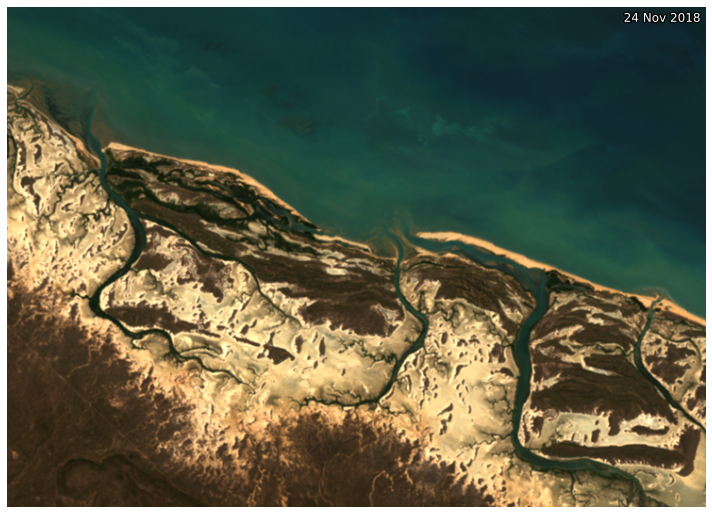

In [52]:
# Compute rolling median
ds_rolling = ds.rolling(time=15, center=True, min_periods=1).median()

# Produce time series animation of red, green and blue bands
animated_timeseries(ds=ds_rolling, 
                    output_path='animated_timeseries.mp4',  
                    bands=['nbart_red', 'nbart_green', 'nbart_blue'],
                    interval=80, 
                    width_pixels=700,
#                     title='Time-series animation',
                    percentile_stretch=[0.01, 0.99],
                    annotation_kwargs={'fontsize': 12}) 


<xarray.Dataset>
Dimensions:      (time: 120, x: 316, y: 179)
Coordinates:
  * time         (time) datetime64[ns] 2015-03-05T00:52:49.301227 ... 2018-12-18T00:48:44.216845
  * y            (y) float64 -1.73e+06 -1.73e+06 ... -1.736e+06 -1.736e+06
  * x            (x) float64 5.904e+05 5.904e+05 ... 5.998e+05 5.999e+05
Data variables:
    nbart_red    (time, y, x) float32 407.0 395.0 378.0 ... 964.0 967.0 969.0
    nbart_green  (time, y, x) float32 863.0 843.0 824.0 ... 822.0 843.0 826.0
    nbart_blue   (time, y, x) float32 700.0 692.0 679.0 ... 621.0 569.0 588.0